In [1]:
import gymnasium as gym
import numpy as np
import causal_gym
from gym.wrappers import RecordVideo
from time import sleep

with open('windy_gridworld_optimal_values.npy', 'rb') as f:
    opt_val = np.load(f)

with open('windy_gridworld_transition.npy', 'rb') as f:
    opt_ps = np.load(f)


env = gym.make('causal_gym/WindyGridWorld-v0', render_mode="rgb_array", size = 3)
env = RecordVideo(env, video_folder="./save_videos1", video_length=10000)

pygame 2.5.2 (SDL 2.28.3, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


/opt/homebrew/lib/python3.11/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /Users/junzhez/git/cauasl-rl/save_videos1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/opt/homebrew/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_wrapper_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(


In [2]:
def value_iteration(ps, policy):
    theta = 0.1
    max_iterations = 10
    gamma = 1 
    values = np.zeros([env.size, env.size])
    for j in range(max_iterations):
        err = 0.0
        new_values = np.zeros([env.size, env.size])
        for x in range(env.size):
            for y in range(env.size):
                qtable = np.zeros(env.action_space.n)

                if x != int(env.size / 2) or y != int(env.size - 1):
                    for a in range(env.action_space.n):
                        # Calculate the value of Q(s,a)
                        new_value = -1
                        for new_x in range(env.size):
                            for new_y in range(env.size):
                                new_value += ps[x, y, a, new_x, new_y] * gamma * values[new_x, new_y]

                        qtable[a] = new_value

                max_q = qtable[policy[x, y]]

                err = np.max([err, np.abs(values[x, y] - max_q)])
                new_values[x, y] = max_q

        values = new_values
        # Terminate if the value function has converged
        if err < theta:
            break
        
    return values

In [3]:
T = 1000
K = 1

regrets = np.zeros(T)

In [4]:
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 1
delta = 0.1


# For plotting metrics
total_epochs = 0

for k in range(K):
    ns = np.ones([env.size, env.size, env.action_space.n, env.size, env.size], dtype=int)
    ps = np.zeros([env.size, env.size, env.action_space.n, env.size, env.size])

    regret = 0
    for i in range(T):
        policy = np.zeros([env.size, env.size], dtype=np.int8)

        for x in range(env.size):
            for y in range(env.size):
                for a in range(env.action_space.n):
                    ps[x, y, a] = np.random.dirichlet(ns[x, y, a].reshape(1, env.size*env.size)[0], 1).reshape(env.size, env.size)

        theta = 0.1
        max_iterations = 10
        values = np.zeros([env.size, env.size])
        for j in range(max_iterations):
                err = 0.0
                new_values = np.zeros([env.size, env.size])
                for x in range(env.size):
                    for y in range(env.size):
                        qtable = np.zeros(env.action_space.n)

                        if x != int(env.size / 2) or y != int(env.size - 1):
                            for a in range(env.action_space.n):
                                # Calculate the value of Q(s,a)
                                new_value = -1
                                for new_x in range(env.size):
                                    for new_y in range(env.size):
                                        new_value += ps[x, y, a, new_x, new_y] * gamma * values[new_x, new_y]

                                qtable[a] = new_value

                        max_q = np.max(qtable)
                        policy[x, y] = np.argmax(qtable)

                        err = np.max([err, np.abs(values[x, y] - max_q)])
                        new_values[x, y] = max_q

                values = new_values
                # Terminate if the value function has converged
                if err < theta:
                    break

        state, _ = env.reset()

        opt_v = opt_val[state['agent'][0], state['agent'][1]]
        rewards = value_iteration(opt_ps, policy)[state['agent'][0], state['agent'][1]]
        
        epochs = 0

        done = False
        terminated = False
        while not done and not terminated:
            action = policy[state['agent'][0], state['agent'][1]]

            next_state, reward, done, terminated, info = env.do(action)
            
            ns[state['agent'][0], state['agent'][1], action, next_state['agent'][0], next_state['agent'][1]] += 1

            state = next_state
            epochs += 1    

        total_epochs += epochs
        regret += opt_v - rewards
        regrets[i] += regret

        if (i+1) % 100 == 0:
            clear_output(wait=True)
            print(f"Repetition {k}, Episode: {i}")
            print(np.transpose(policy))

print("Training finished.\n")
regrets = regrets / K
env.close()

Repetition 0, Episode: 999
[[2 2 2]
 [2 2 2]
 [1 0 3]]
Training finished.

Moviepy - Building video /Users/junzhez/git/cauasl-rl/save_videos1/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/junzhez/git/cauasl-rl/save_videos1/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/junzhez/git/cauasl-rl/save_videos1/rl-video-episode-0.mp4


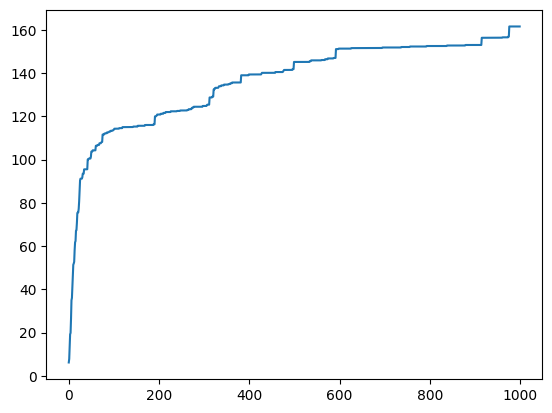

In [5]:
import matplotlib.pyplot as plt
plt.plot(range(T), regrets)
plt.show()

In [6]:
#with open('windy_gridworld_ts.regret', 'wb') as f:
#    np.save(f, regrets)
